# CAPSTONE PROJECT

## TABLE OF CONTENT


#### <b> <a href='#chapter1'>1. Data Collection </a>  
    
#### <b> <a href='#chapter2'> 2. Data Preprocessing </a>
    
#### <b> <a href='#chapter3'>3. Model Building </a>
   
#### <b> <a href='#chapter4'>4. Portfolio Performance </a>  

#### <b> <a href='#chapter5'>5. Future Prediction </a>  


# <h2> <b> 1. Data Collection <a class='anchor' id='chapter1'></a>

- Equity ETF: S&P500 (SPY)
- Bond ETF: Vanguard Total Bond Market Index Fund (BND)
- Commodities ETF: abrdn Bloomberg All Commodity Longer Dated Strategy K-1 Free ETF (BCD)
- Cryptocurrency: Bitcoin (BTC)

**Collect data from yfinance**

In [69]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy.optimize import minimize
import cvxpy as cp

In [70]:
df = yf.download(tickers = 'SPY BND BCD BTC-USD', interval = '1d', end = '2024-01-01')['Adj Close']
df.dropna(inplace = True)
df

[*********************100%%**********************]  4 of 4 completed


Ticker,BCD,BND,BTC-USD,SPY
Date,,,,
2017-03-31,20.023762,67.199837,1071.790039,210.044342
2017-04-03,20.095844,67.444084,1143.810059,209.679031
2017-04-04,20.095844,67.369301,1133.250000,209.812653
2017-04-05,20.095844,67.427422,1124.780029,209.188965
2017-04-06,20.171936,67.452370,1182.680054,209.777023
...,...,...,...,...
2023-12-22,30.780001,73.148201,43997.902344,473.649994
2023-12-26,30.990000,73.217995,42520.402344,475.649994
2023-12-27,31.049999,73.686646,43442.855469,476.510010


The data contains daily prices of BCD, BND, BTC, and SPY from 31/03/2017 to 29/12/2023. There are 1699 observations.

# <h2> <b> 2. Data Preprocessing <a class='anchor' id='chapter2'></a>

We create a dataframe called **returns** which calculates daily returns of each asset

In [71]:
returns = df.pct_change(1).dropna()
returns

Ticker,BCD,BND,BTC-USD,SPY
Date,,,,
2017-04-03,0.003600,0.003635,0.067196,-0.001739
2017-04-04,0.000000,-0.001109,-0.009232,0.000637
2017-04-05,0.000000,0.000863,-0.007474,-0.002973
2017-04-06,0.003786,0.000370,0.051477,0.002811
2017-04-07,-0.000199,-0.002217,-0.004887,-0.001019
...,...,...,...,...
2023-12-22,0.001627,-0.000667,0.002935,0.002010
2023-12-26,0.006823,0.000954,-0.033581,0.004223
2023-12-27,0.001936,0.006401,0.021694,0.001808


#### Graph daily price and returns

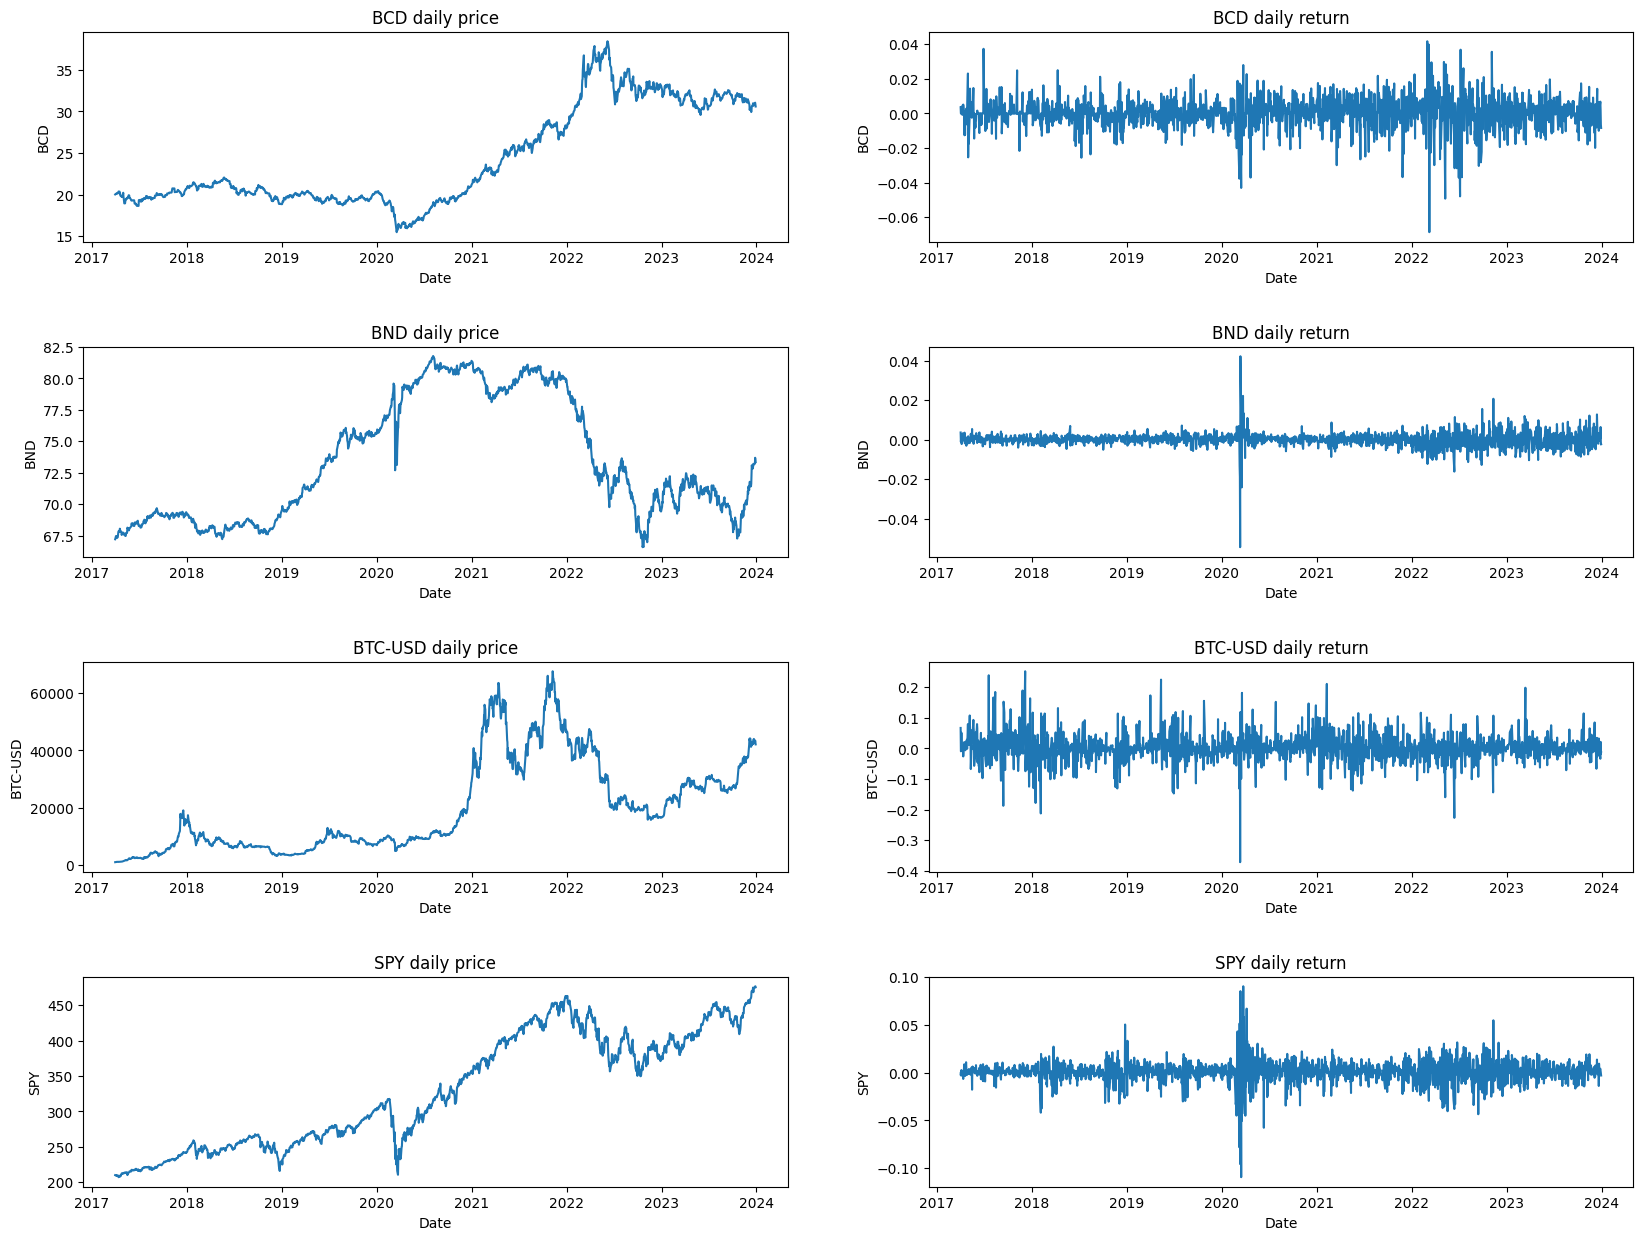

In [72]:
col = list(df.columns)


fig,axes = plt.subplots(4,2,figsize=(20,15))
for index,col in enumerate(col):
    x, y = index, 0
    sns.lineplot(x= df.index, y=df[col],ax=axes[x,y]).set(title=col+' daily price')
    x, y = index, 1
    sns.lineplot(x = returns.index, y= returns[col],ax=axes[x,y]).set(title=col+' daily return')

plt.subplots_adjust(hspace=0.5)

It can be seen from the graph that:
- During the period of observation, all four assets show erractic patterns
- Prices were stable in the period from 2017 to 2020
- During the first half of 2020, BCD, BND, and SPY all fell sharply.
- From there, all four assets escalated until the beginning of 2022. All of them experienced the bear period, then remained quite stagnant.

#### Define allocation for model training

We use **cvxpy** to solve the problem to get maximum daily returns.

Assume $w_1, w_2, w_3, w_4$ and $r_1, r_2, r_3, r_4$ are daily weights and daily returns of BCD, BND, BTC, and SPY respectively.
We know $r_1, r_2, r_3, r_4$, now we find $w_1, w_2, w_3, w_4$ to maximize the result of $w_1*r_1 + w_2*r_2 + w_3*r_3 + w_4*r_4$


In [73]:
# Number of assets
num_assets = len(returns.columns)

# Create a DataFrame to store daily weights
daily_weights = pd.DataFrame(index=returns.index, columns=returns.columns)

# Portfolio Optimization
for date in returns.index:
    current_returns = returns.loc[date].values
    weights = cp.Variable(num_assets)

    # Objective function - Maximize expected return
    objective = cp.Maximize(current_returns @ weights)

    # Constraints - Weights sum to 1 and ensure non-negative weights
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Store the optimal weights for the current date
    daily_weights.loc[date] = weights.value

# Add the daily weights to the returns DataFrame
returns = pd.concat([returns, daily_weights], axis=1)

We justify the data types and names of the columns.
BCD, BND, BTC-USD, SPY are columns of daily returns of each asset.
BCD_w, BND_w, BTC-USD_w, SPY_w are columns of daily weights of each asset.


In [74]:
returns.columns = ['BCD','BND','BTC-USD','SPY','BCD_w','BND_w','BTC-USD_w','SPY_w']
returns = returns.astype('float')
returns.dtypes

BCD          float64
BND          float64
BTC-USD      float64
SPY          float64
BCD_w        float64
BND_w        float64
BTC-USD_w    float64
SPY_w        float64
dtype: object

Here is the result

In [75]:
returns

,BCD,BND,BTC-USD,SPY,BCD_w,BND_w,BTC-USD_w,SPY_w
Date,,,,,,,,
2017-04-03,0.003600,0.003635,0.067196,-0.001739,4.234397e-10,4.217006e-10,1.000000e+00,6.575675e-10
2017-04-04,0.000000,-0.001109,-0.009232,0.000637,9.566505e-08,2.754018e-07,5.396906e-08,9.999996e-01
2017-04-05,0.000000,0.000863,-0.007474,-0.002973,8.253151e-08,9.999997e-01,5.433112e-08,1.228967e-07
2017-04-06,0.003786,0.000370,0.051477,0.002811,3.984458e-10,4.133772e-10,1.000000e+00,4.003432e-10
2017-04-07,-0.000199,-0.002217,-0.004887,-0.001019,9.999995e-01,2.630724e-07,1.162504e-07,7.955261e-08
...,...,...,...,...,...,...,...,...
2023-12-22,0.001627,-0.000667,0.002935,0.002010,2.267530e-07,1.352636e-07,9.999996e-01,5.961935e-08
2023-12-26,0.006823,0.000954,-0.033581,0.004223,1.000000e+00,1.739725e-08,4.398125e-09,1.059935e-08
2023-12-27,0.001936,0.006401,0.021694,0.001808,1.003806e-09,1.218470e-09,1.000000e+00,9.979827e-10


# <h2> <b> 3. Model Building <a class='anchor' id='chapter3'></a>

### 3.1. Use LSTM to predict price

The function **prediction_model** is designed to:
- Use prices of 5 previous day to predict prices for the next day using LSTM
- Predict daily prices of the assets for the next year (in this case, the year of 2024)

In [76]:
def prediction_model(df,ticker, time_seq):
    ticker_close = df[ticker].values.reshape(-1, 1)

    # Normalize data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    ticker_close_scaled = scaler.fit_transform(ticker_close)

    # Function to prepare data for LSTM
    def prepare_data(data_scaled):
        X, y = [], []
        for i in range(time_seq, len(data_scaled)):
            X.append(data_scaled[i-time_seq:i, 0])
            y.append(data_scaled[i, 0])
        return np.array(X), np.array(y)

    # Prepare data for training
    X_ticker, y_ticker = prepare_data(ticker_close_scaled)

    # Reshape data for LSTM input (batch_size, timesteps, input_dim)
    X_ticker = np.reshape(X_ticker, (X_ticker.shape[0], X_ticker.shape[1], 1))

    # Function to create LSTM model
    def create_lstm_model(X_train):
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50, return_sequences=True))
        model.add(LSTM(units=50))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Function to train LSTM model
    def train_lstm_model(model, X_train, y_train, epochs, batch_size):
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    def make_predictions(model, X):
        predictions = model.predict(X)
        predictions = scaler.inverse_transform(predictions)
        return predictions

    # Function to evaluate the model
    def evaluate_model(model, X, y):
        predictions = make_predictions(model, X)
        y = y.reshape(-1, 1)  # Reshape y to 2D array
        mse = mean_squared_error(scaler.inverse_transform(y), predictions)
        return mse

    # Function to plot predictions
    def plot_predictions(actual, predictions, title):
        plt.figure(figsize=(15, 8))
        plt.plot(actual, label='Actual Price')
        plt.plot(predictions, label='Predicted Price')
        plt.legend()
        plt.title(title)
        plt.show()

    # Train LSTM models
    model_ticker = create_lstm_model(X_ticker)
    train_lstm_model(model_ticker, X_ticker, y_ticker, epochs=10, batch_size=32)

    # Evaluate and plot predictions
    mse_ticker = evaluate_model(model_ticker, X_ticker, y_ticker)
    print('Mean Squared Error',ticker,':',mse_ticker)
    ticker_predictions = make_predictions(model_ticker, X_ticker)

    # Predict BTC prices for the future
    future_time_steps = 90  # Assuming you want to predict for the next quarter

    # Use the last 'time_steps' values from the original data to predict the future
    future_data = ticker_close_scaled[-time_seq:]

    for _ in range(future_time_steps):
        X_future = future_data[-time_seq:].reshape(1, time_seq, 1)
        predicted_price = model_ticker.predict(X_future)[0, 0]
        future_data = np.append(future_data, [[predicted_price]], axis=0)

    # Inverse transform the normalized data to get the actual prices
    predicted_prices = scaler.inverse_transform(future_data[-future_time_steps:].reshape(-1, 1))

    # Create a DataFrame for the predicted prices
    predicted_dates = pd.date_range(start=df.index[-1], periods=future_time_steps + 1, freq='D')[1:]
    predicted_df = pd.DataFrame({ticker + '_predicted_price': predicted_prices.flatten()}, index=predicted_dates)

    # Save the predicted prices in the existing DataFrame
    df = pd.concat([df, predicted_df], axis=1)

    plot_predictions(ticker_close[time_seq:], ticker_predictions, title = ticker + ' Price Prediction')

    return df

Epoch 1/10
53/53 [==============================] - 7s 11ms/step - loss: 0.0699
Epoch 2/10
53/53 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 3/10
53/53 [==============================] - 1s 11ms/step - loss: 8.3527e-04
Epoch 4/10
53/53 [==============================] - 1s 11ms/step - loss: 7.1735e-04
Epoch 5/10
53/53 [==============================] - 1s 11ms/step - loss: 6.8629e-04
Epoch 6/10
53/53 [==============================] - 1s 11ms/step - loss: 6.4859e-04
Epoch 7/10
53/53 [==============================] - 1s 13ms/step - loss: 6.3875e-04
Epoch 8/10
53/53 [==============================] - 1s 18ms/step - loss: 6.5181e-04
Epoch 9/10
53/53 [==============================] - 1s 19ms/step - loss: 6.4246e-04
Epoch 10/10
53/53 [==============================] - 1s 4ms/step
Mean Squared Error SPY : 44.7790189611018
1/1 [==============================] - 0s 33ms/step


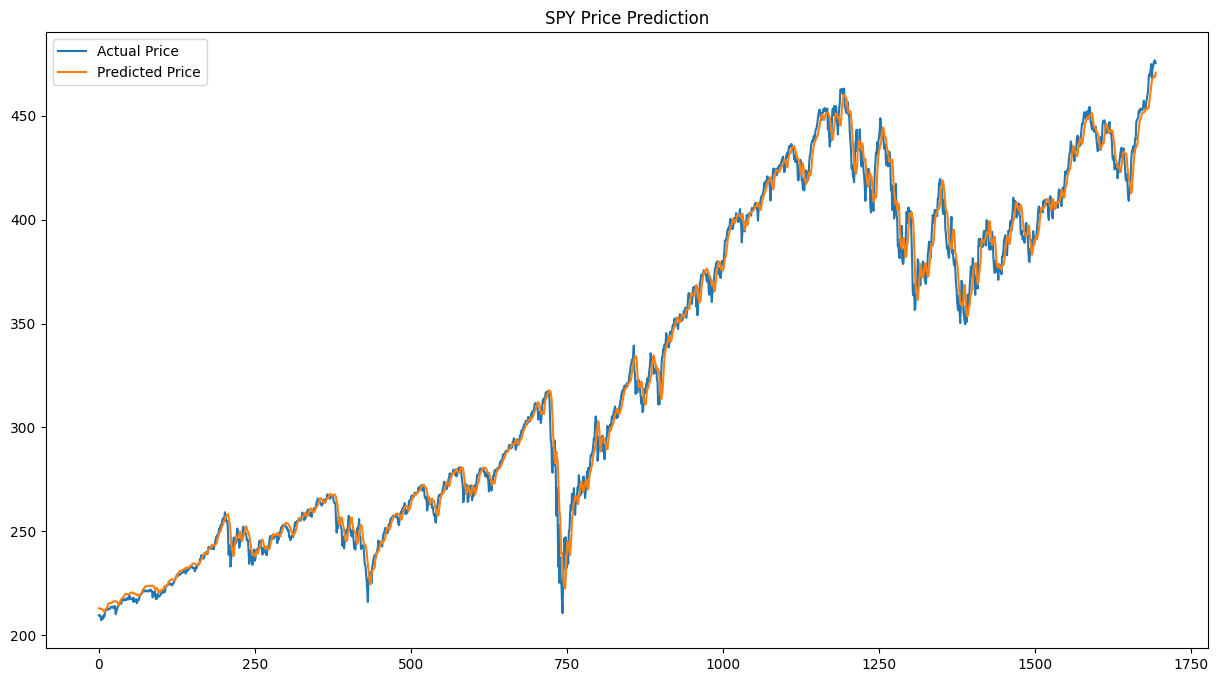

In [77]:
model_SPY = prediction_model(df,'SPY',5)

Epoch 1/10
53/53 [==============================] - 6s 13ms/step - loss: 0.0649
Epoch 2/10
53/53 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 3/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 4/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 5/10
53/53 [==============================] - 1s 11ms/step - loss: 9.6192e-04
Epoch 6/10
53/53 [==============================] - 1s 14ms/step - loss: 9.3722e-04
Epoch 7/10
53/53 [==============================] - 1s 17ms/step - loss: 9.7414e-04
Epoch 8/10
53/53 [==============================] - 1s 19ms/step - loss: 9.4190e-04
Epoch 9/10
53/53 [==============================] - 1s 14ms/step - loss: 9.5602e-04
Epoch 10/10
53/53 [==============================] - 1s 5ms/step
Mean Squared Error BND : 0.2079290141519684
1/1 [==============================] - 0s 32ms/step


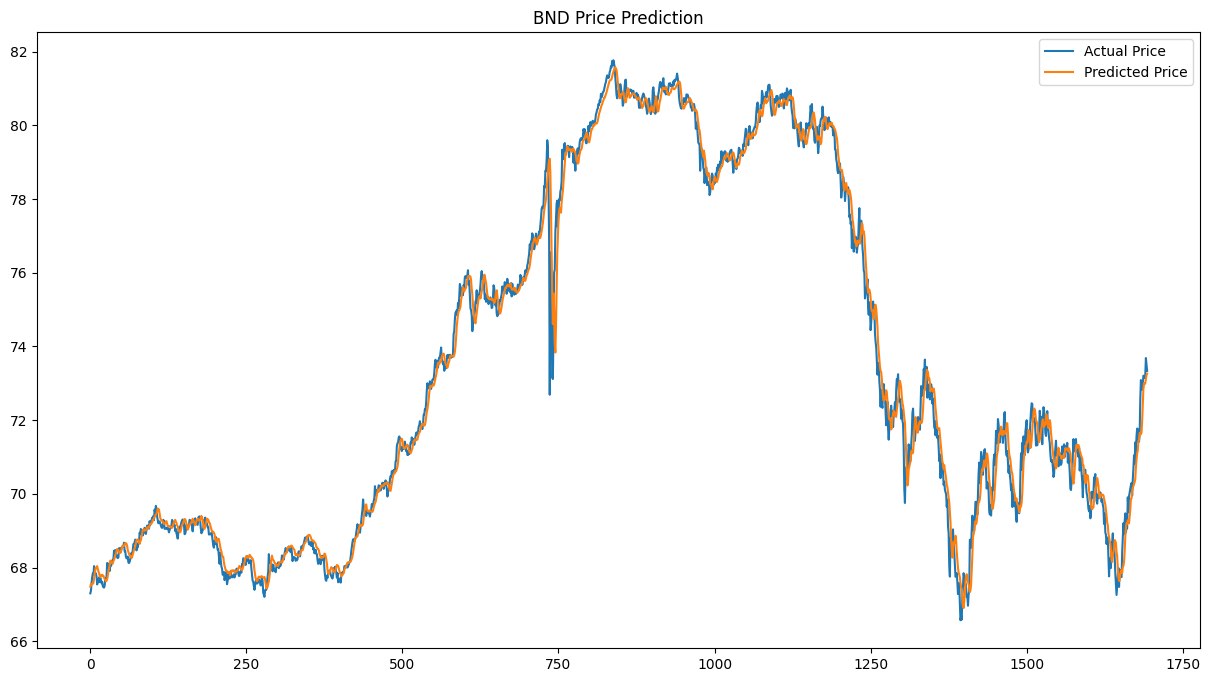

In [78]:
model_BND = prediction_model(df,'BND',5)

Epoch 1/10
53/53 [==============================] - 6s 11ms/step - loss: 0.0481
Epoch 2/10
53/53 [==============================] - 1s 11ms/step - loss: 9.4193e-04
Epoch 3/10
53/53 [==============================] - 1s 10ms/step - loss: 6.3980e-04
Epoch 4/10
53/53 [==============================] - 1s 10ms/step - loss: 5.2631e-04
Epoch 5/10
53/53 [==============================] - 1s 10ms/step - loss: 5.0914e-04
Epoch 6/10
53/53 [==============================] - 1s 11ms/step - loss: 4.7273e-04
Epoch 7/10
53/53 [==============================] - 1s 10ms/step - loss: 4.4223e-04
Epoch 8/10
53/53 [==============================] - 1s 10ms/step - loss: 4.2163e-04
Epoch 9/10
53/53 [==============================] - 1s 19ms/step - loss: 4.2793e-04
Epoch 10/10
53/53 [==============================] - 1s 4ms/step
Mean Squared Error BCD : 0.23350771934564207
1/1 [==============================] - 0s 22ms/step


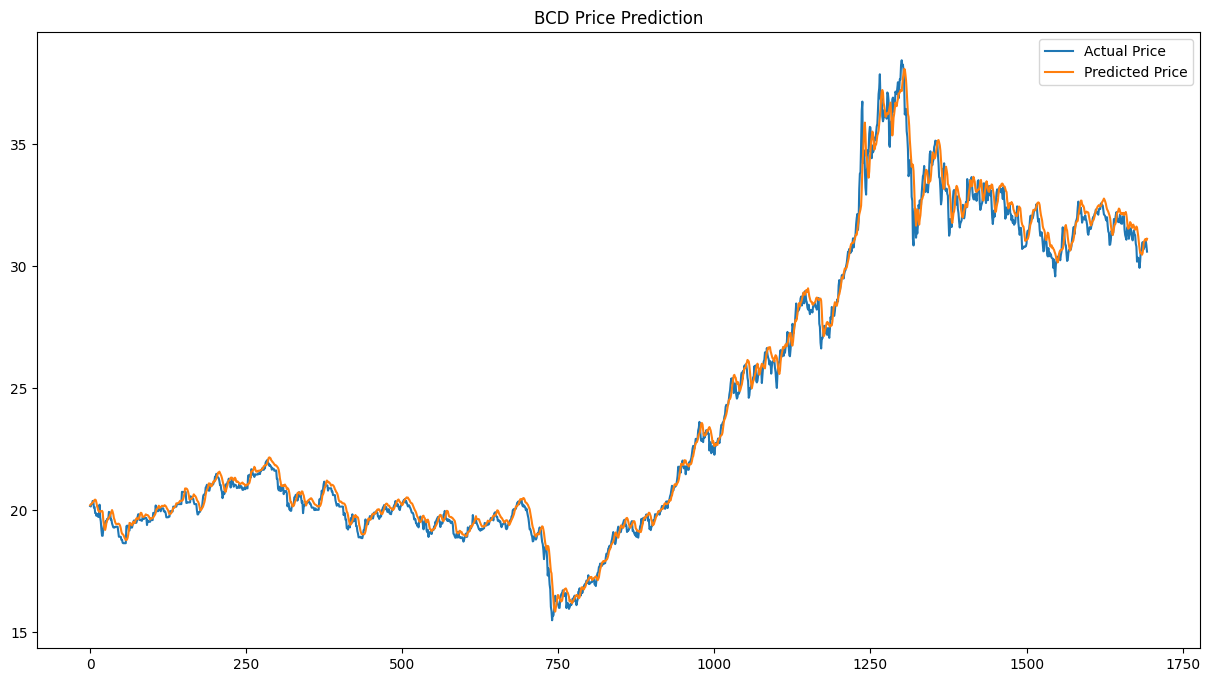

In [79]:
model_BCD = prediction_model(df,'BCD',5)

Epoch 1/10
53/53 [==============================] - 7s 11ms/step - loss: 0.0306
Epoch 2/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 3/10
53/53 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 4/10
53/53 [==============================] - 1s 16ms/step - loss: 9.3896e-04
Epoch 5/10
53/53 [==============================] - 1s 17ms/step - loss: 9.7778e-04
Epoch 6/10
53/53 [==============================] - 1s 18ms/step - loss: 9.6397e-04
Epoch 7/10
53/53 [==============================] - 1s 12ms/step - loss: 9.5798e-04
Epoch 8/10
53/53 [==============================] - 1s 12ms/step - loss: 9.6208e-04
Epoch 9/10
53/53 [==============================] - 1s 11ms/step - loss: 9.7946e-04
Epoch 10/10
53/53 [==============================] - 1s 4ms/step
Mean Squared Error BTC-USD : 4051842.0265753814
1/1 [==============================] - 0s 32ms/step


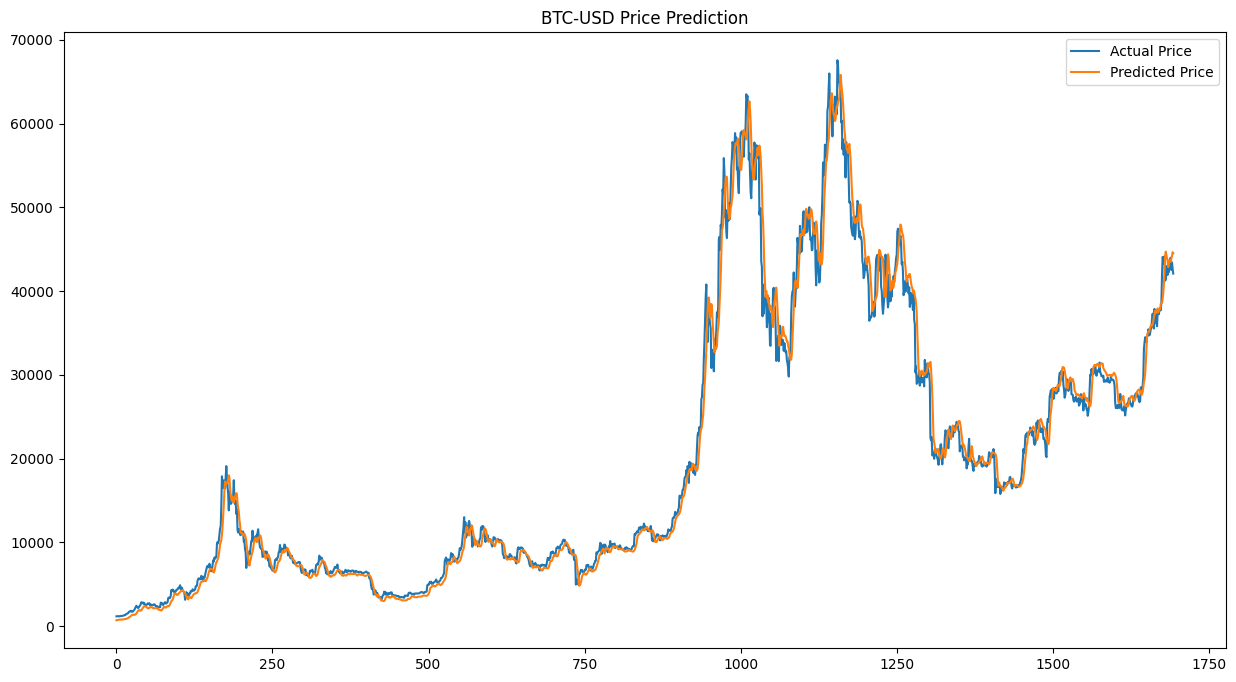

In [80]:
model_BTC = prediction_model(df,'BTC-USD',5)

Now we add the actual price and predicted price into one dataframe

In [81]:
common_columns = df.columns

# Concatenate the DataFrames along the rows
result_df = pd.concat([model_BCD, model_BND, model_BTC, model_SPY], axis = 1)
# Remove duplicated columns based on common columns
result_df = result_df.loc[:, ~result_df.columns.duplicated()]

result_df

,BCD,BND,BTC-USD,SPY,BCD_predicted_price,BND_predicted_price,BTC-USD_predicted_price,SPY_predicted_price
2017-03-31,20.023762,67.199837,1071.790039,210.044342,NaN,NaN,NaN,NaN
2017-04-03,20.095844,67.444084,1143.810059,209.679031,NaN,NaN,NaN,NaN
2017-04-04,20.095844,67.369301,1133.250000,209.812653,NaN,NaN,NaN,NaN
2017-04-05,20.095844,67.427422,1124.780029,209.188965,NaN,NaN,NaN,NaN
2017-04-06,20.171936,67.452370,1182.680054,209.777023,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-03-24,NaN,NaN,NaN,NaN,35.344491,73.631548,59205.702956,440.815902
2024-03-25,NaN,NaN,NaN,NaN,35.369062,73.634062,59280.623354,440.667254
2024-03-26,NaN,NaN,NaN,NaN,35.393140,73.636578,59353.601680,440.521063
2024-03-27,NaN,NaN,NaN,NaN,35.416727,73.639096,59424.637934,440.377315


We label the weights as 0 and 1 for model training. Here we use RF algorithm

In [82]:
returns['SPY_Label'] = (returns['SPY_w'] >= 0.5).astype(int)
returns['BND_Label'] = (returns['BND_w'] >= 0.5).astype(int)
returns['BCD_Label'] = (returns['BCD_w'] >= 0.5).astype(int)
returns['BTC-USD_Label'] = (returns['BTC-USD_w'] >= 0.5).astype(int)


# Features and target variable
train_size = int(len(returns) * 0.8)
train, test = returns[:train_size], returns[train_size:]

# Model Training
features = ['SPY', 'BND', 'BCD', 'BTC-USD']
labels = ['SPY_Label', 'BND_Label', 'BCD_Label', 'BTC-USD_Label']
X_train, y_train = train[features], train[labels]
X_test, y_test = test[features], test[labels]

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [83]:
# Predictions
predictions = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9235294117647059


Apply **predict_proba** to show predicted allocation

In [84]:
X = returns[features]

# Predict probabilities for each label on the test set
proba_predictions = rf_model.predict_proba(X)

# Convert proba_predictions to a NumPy array
proba_predictions_array = np.array(proba_predictions)

# Extract the probability of the positive class for each label
proba_positive_class = proba_predictions_array[:, :, 1].T

# Create a DataFrame with predicted probabilities
proba_df = pd.DataFrame(proba_positive_class, columns=[f'{label}_Proba_Predicted' for label in labels])

# Concatenate the predicted probabilities DataFrame with the original DataFrame
returns = pd.concat([returns.reset_index(drop=True), proba_df], axis=1)

# proba_df.sum(axis = 1)

In [85]:
returns.set_index(df.index[1:],inplace = True)
returns

,BCD,BND,BTC-USD,SPY,BCD_w,BND_w,BTC-USD_w,SPY_w,SPY_Label,BND_Label,BCD_Label,BTC-USD_Label,SPY_Label_Proba_Predicted,BND_Label_Proba_Predicted,BCD_Label_Proba_Predicted,BTC-USD_Label_Proba_Predicted
Date,,,,,,,,,,,,,,,,
2017-04-03,0.003600,0.003635,0.067196,-0.001739,4.234397e-10,4.217006e-10,1.000000e+00,6.575675e-10,0,0,0,1,0.00,0.00,0.00,1.00
2017-04-04,0.000000,-0.001109,-0.009232,0.000637,9.566505e-08,2.754018e-07,5.396906e-08,9.999996e-01,1,0,0,0,0.89,0.02,0.09,0.00
2017-04-05,0.000000,0.000863,-0.007474,-0.002973,8.253151e-08,9.999997e-01,5.433112e-08,1.228967e-07,0,1,0,0,0.00,0.98,0.02,0.00
2017-04-06,0.003786,0.000370,0.051477,0.002811,3.984458e-10,4.133772e-10,1.000000e+00,4.003432e-10,0,0,0,1,0.00,0.00,0.00,1.00
2017-04-07,-0.000199,-0.002217,-0.004887,-0.001019,9.999995e-01,2.630724e-07,1.162504e-07,7.955261e-08,0,0,1,0,0.03,0.05,0.92,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.001627,-0.000667,0.002935,0.002010,2.267530e-07,1.352636e-07,9.999996e-01,5.961935e-08,0,0,0,1,0.41,0.03,0.05,0.51
2023-12-26,0.006823,0.000954,-0.033581,0.004223,1.000000e+00,1.739725e-08,4.398125e-09,1.059935e-08,0,0,1,0,0.00,0.00,1.00,0.00
2023-12-27,0.001936,0.006401,0.021694,0.001808,1.003806e-09,1.218470e-09,1.000000e+00,9.979827e-10,0,0,0,1,0.01,0.03,0.00,0.96


# <h2> <b> 4. Portfolio Performance <a class='anchor' id='chapter4'></a>

Assume that transaction fee is 0.04%

Here is the performace of each individual asset

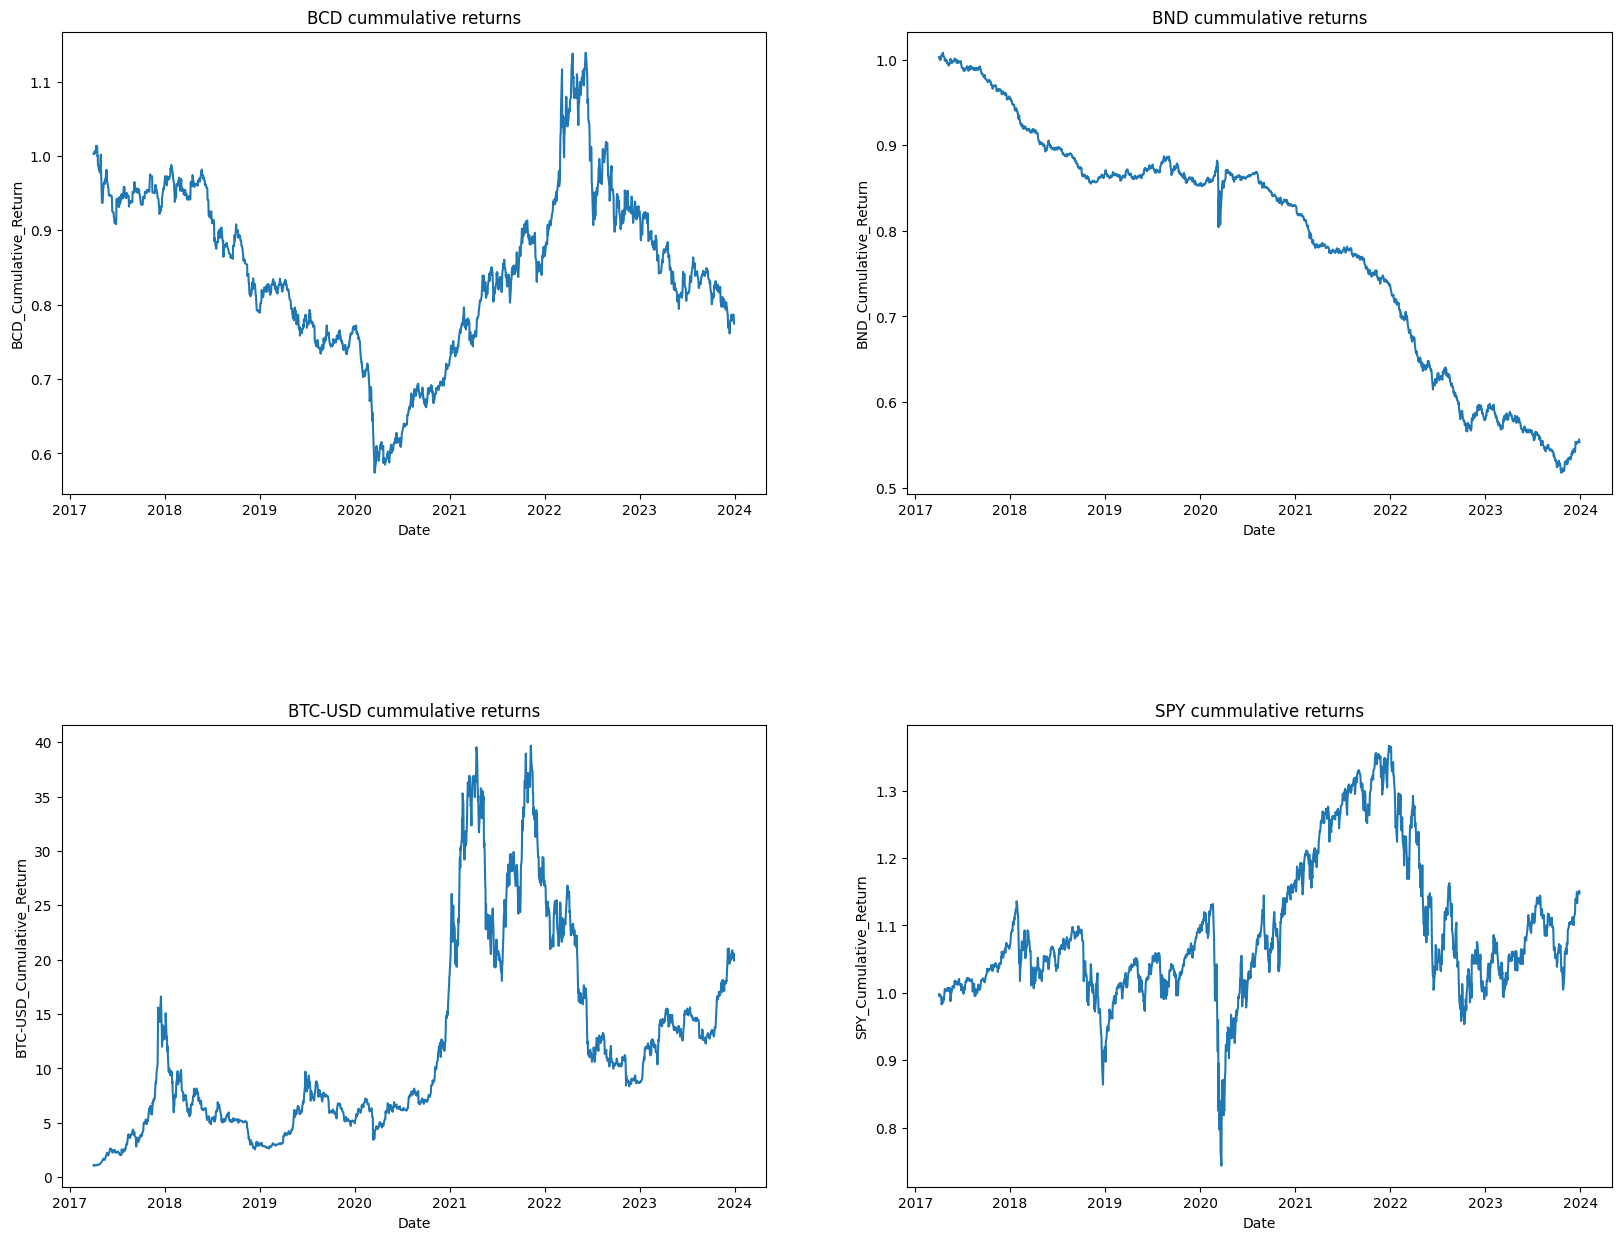

In [86]:
fig,axes = plt.subplots(2,2,figsize=(20,15))
for index, col in enumerate(['BCD','BND','BTC-USD','SPY']):
  returns[col + '_Cumulative_Return'] = (returns[col] - 0.04/100 + 1).cumprod()
  x = index//2
  y = index%2
  sns.lineplot(x= returns.index, y=returns[col+ '_Cumulative_Return'],ax=axes[x,y]).set(title=col+' cummulative returns')

plt.subplots_adjust(hspace=0.5)

Portfolio performance

In [87]:
returns.set_index(df.index[1:],inplace = True)
# Calculate portfolio returns
returns['Portfolio_Return'] = (returns['SPY_Label_Proba_Predicted'] * returns['SPY'] +
                                 returns['BND_Label_Proba_Predicted'] * returns['BND'] +
                                 returns['BCD_Label_Proba_Predicted'] * returns['BCD'] +
                                  returns['BTC-USD_Label_Proba_Predicted'] * returns['BTC-USD'])
fig1 = px.line(returns, y="Portfolio_Return", title='Portfolio Daily Returns')
fig1.show()

# Calculate cumulative portfolio returns
returns['Cumulative_Return'] = (returns['Portfolio_Return'] - 0.04/100 + 1).cumprod()
# Plot cumulative portfolio returns

fig2 = px.line(returns, y="Cumulative_Return", title='Cumulative Portfolio Returns')
fig2.show()

# Calculate portfolio volatility
portfolio_volatility = returns['Portfolio_Return'].std()
print('Portfolio Volatility:', portfolio_volatility)

# Calculate portfolio Sharpe ratio
sharpe_ratio = returns['Portfolio_Return'].mean() / portfolio_volatility
print('Sharpe Ratio:', sharpe_ratio)


Portfolio Volatility: 0.028809399825162074
Sharpe Ratio: 0.6796638283097618


Since the return is compounded, it goes up exponentially.

# <h2> <b> 5. Future allocation <a class='anchor' id='chapter5'></a>

We predict the price for the first quarter of 2024 and see the performance of the portfolio.

In [88]:
future_df = result_df[result_df.columns[4:]].dropna()
future_df


,BCD_predicted_price,BND_predicted_price,BTC-USD_predicted_price,SPY_predicted_price
2023-12-30,31.175861,73.330684,44235.598293,471.644673
2023-12-31,31.230629,73.434859,43844.829539,472.343398
2024-01-01,31.211368,73.525822,44070.637075,472.151262
2024-01-02,31.176617,73.426088,44021.696850,471.307873
2024-01-03,31.249849,73.388495,44380.552201,469.962682
...,...,...,...,...
2024-03-24,35.344491,73.631548,59205.702956,440.815902
2024-03-25,35.369062,73.634062,59280.623354,440.667254
2024-03-26,35.393140,73.636578,59353.601680,440.521063
2024-03-27,35.416727,73.639096,59424.637934,440.377315


In [89]:
future_returns = future_df.pct_change(1).dropna()
future_returns.columns = features
future_returns

,SPY,BND,BCD,BTC-USD
2023-12-31,0.001757,0.001421,-0.008834,0.001481
2024-01-01,-0.000617,0.001239,0.005150,-0.000407
2024-01-02,-0.001113,-0.001356,-0.001110,-0.001786
2024-01-03,0.002349,-0.000512,0.008152,-0.002854
2024-01-04,0.007422,0.000438,0.015857,-0.002662
...,...,...,...,...
2024-03-24,0.000710,0.000034,0.001301,-0.000343
2024-03-25,0.000695,0.000034,0.001265,-0.000337
2024-03-26,0.000681,0.000034,0.001231,-0.000332
2024-03-27,0.000666,0.000034,0.001197,-0.000326


In [90]:
X_24 = future_returns[features]

# Predict probabilities for each label on the test set
proba_predictions = rf_model.predict_proba(X_24)

# Convert proba_predictions to a NumPy array
proba_predictions_array = np.array(proba_predictions)

# Extract the probability of the positive class for each label
proba_positive_class = proba_predictions_array[:, :, 1].T

# Create a DataFrame with predicted probabilities
proba_df = pd.DataFrame(proba_positive_class, columns=[f'{label}_Proba_Predicted' for label in labels])

# Concatenate the predicted probabilities DataFrame with the original DataFrame
future_returns = pd.concat([future_returns.reset_index(drop=True), proba_df], axis=1)

In [91]:
future_returns

,SPY,BND,BCD,BTC-USD,SPY_Label_Proba_Predicted,BND_Label_Proba_Predicted,BCD_Label_Proba_Predicted,BTC-USD_Label_Proba_Predicted
0,0.001757,0.001421,-0.008834,0.001481,0.71,0.17,0.02,0.10
1,-0.000617,0.001239,0.005150,-0.000407,0.00,0.02,0.98,0.00
2,-0.001113,-0.001356,-0.001110,-0.001786,0.22,0.19,0.58,0.01
3,0.002349,-0.000512,0.008152,-0.002854,0.01,0.00,0.99,0.00
4,0.007422,0.000438,0.015857,-0.002662,0.04,0.00,0.96,0.00
...,...,...,...,...,...,...,...,...
84,0.000710,0.000034,0.001301,-0.000343,0.30,0.02,0.62,0.06
85,0.000695,0.000034,0.001265,-0.000337,0.36,0.04,0.54,0.06
86,0.000681,0.000034,0.001231,-0.000332,0.36,0.06,0.52,0.06
87,0.000666,0.000034,0.001197,-0.000326,0.36,0.06,0.52,0.06


In [92]:
future_returns.set_index(future_df.index[1:],inplace = True)
# Calculate portfolio returns
future_returns['Portfolio_Return'] = (future_returns['SPY_Label_Proba_Predicted'] * future_returns['SPY'] +
                                 future_returns['BND_Label_Proba_Predicted'] * future_returns['BND'] +
                                 future_returns['BCD_Label_Proba_Predicted'] * future_returns['BCD'] +
                                  future_returns['BTC-USD_Label_Proba_Predicted'] * future_returns['BTC-USD'])

# Calculate cumulative portfolio returns
future_returns['Cumulative_Return'] = (future_returns['Portfolio_Return'] - 0.04/100 + 1).cumprod() + returns['Cumulative_Return'][-1]

# Plot cumulative portfolio returns
fig3 = px.line(future_returns, y="Cumulative_Return", title='2024 Cumulative Portfolio Returns')
fig3.show()

# Calculate portfolio volatility
portfolio_volatility = future_returns['Portfolio_Return'].std()
print('Portfolio Volatility:', portfolio_volatility)

# Calculate portfolio Sharpe ratio
sharpe_ratio = future_returns['Portfolio_Return'].mean() / portfolio_volatility
print('Sharpe Ratio:', sharpe_ratio)


Portfolio Volatility: 0.002232556876365057
Sharpe Ratio: 1.3982307870572463
